# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [2]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [3]:
## List mzXML files
mzXMLs <- list.files(path = "PGC_pos", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Control", 5), rep("alpha-PCYP", 5), 
                  rep("QC", 7))
sample.order <- c(8,10,15,7,13,16,12,9,14,6,1,2,3,4,5,11,17)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.99 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 17695 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Fri Oct 22 13:58:52 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Fri Oct 22 13:58:52 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 17 (17 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] pQC_1.mzXML...  [17] pQC_7.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0117 F01.S0118 ... F17.S1157 (17695 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [4]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")

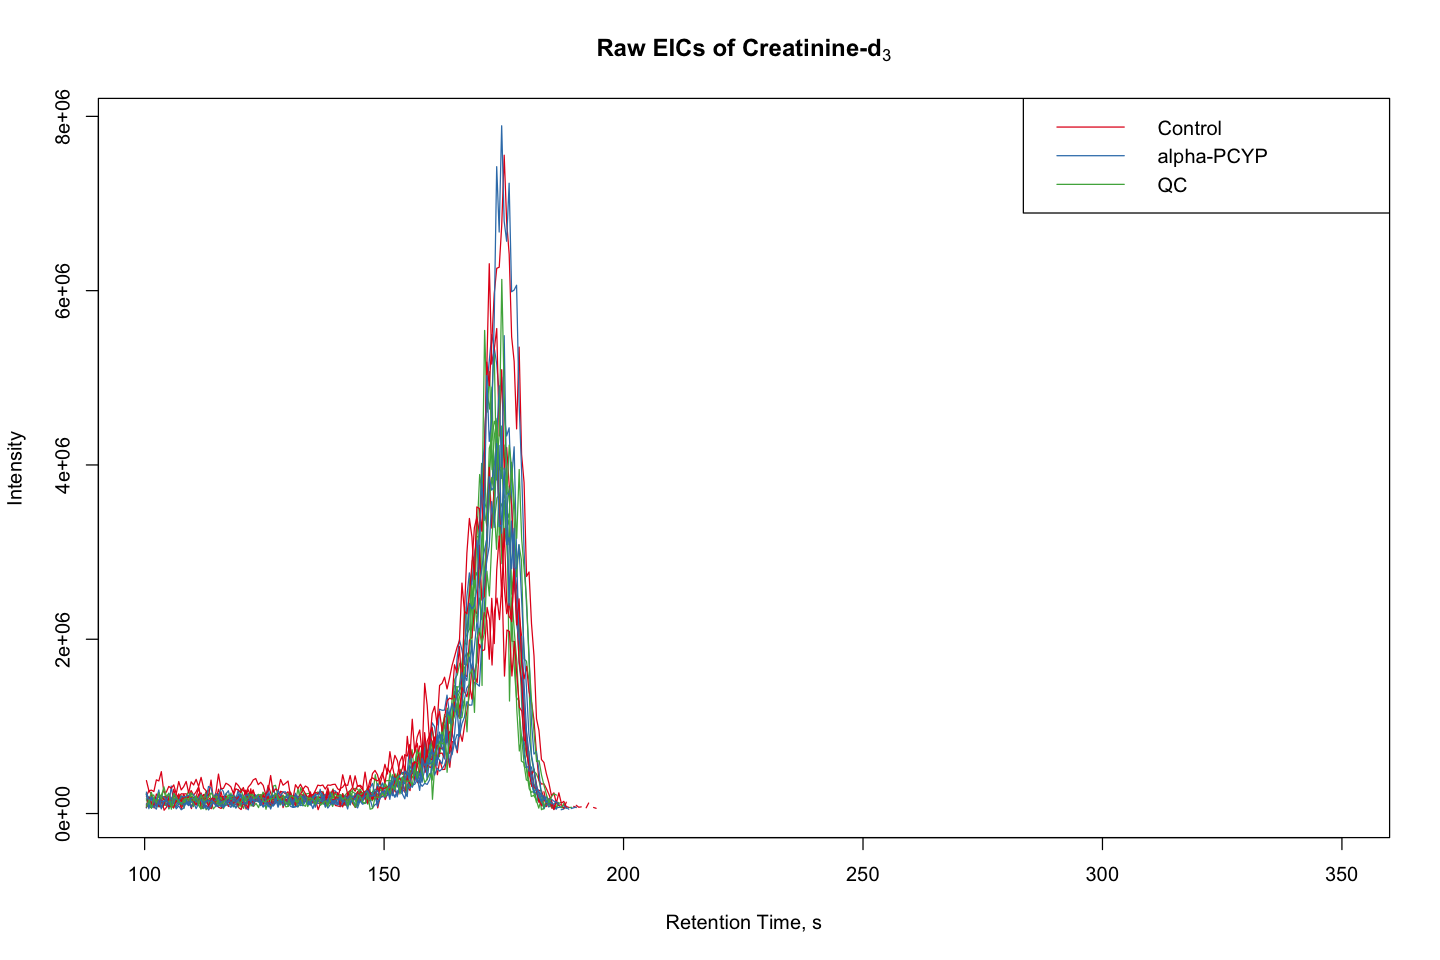

In [5]:
## Plot raw EICs of creatinine-d3 (m/z 117.0856, 25 s)
cread3.raw <- chromatogram(raw, mz = c(117.0841, 117.0871), rt = c(100, 350))

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

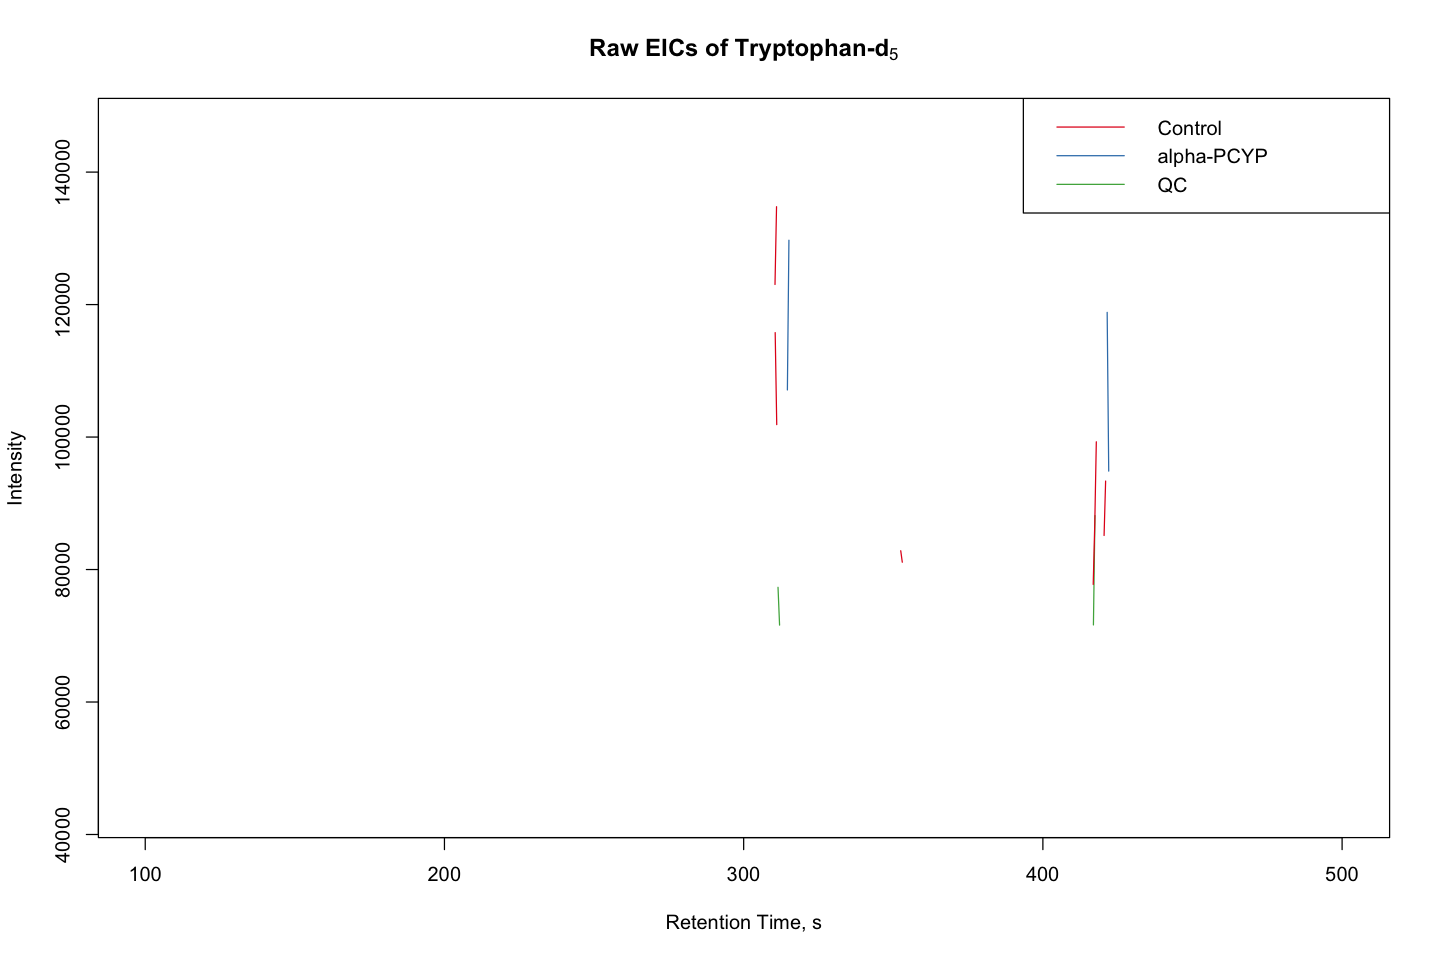

In [7]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Control", "alpha-PCYP", "QC")


## Plot tryptophan-d5 before processing (m/z 210.1291, 168 s)
trpd5.raw <- chromatogram(raw, mz = c(210.1280, 210.1296), rt = c(100, 500))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

Fehler in x$.self$finalize() : Versuch eine Nicht-Funktion anzuwenden

Fehler in x$.self$finalize() : Versuch eine Nicht-Funktion anzuwenden



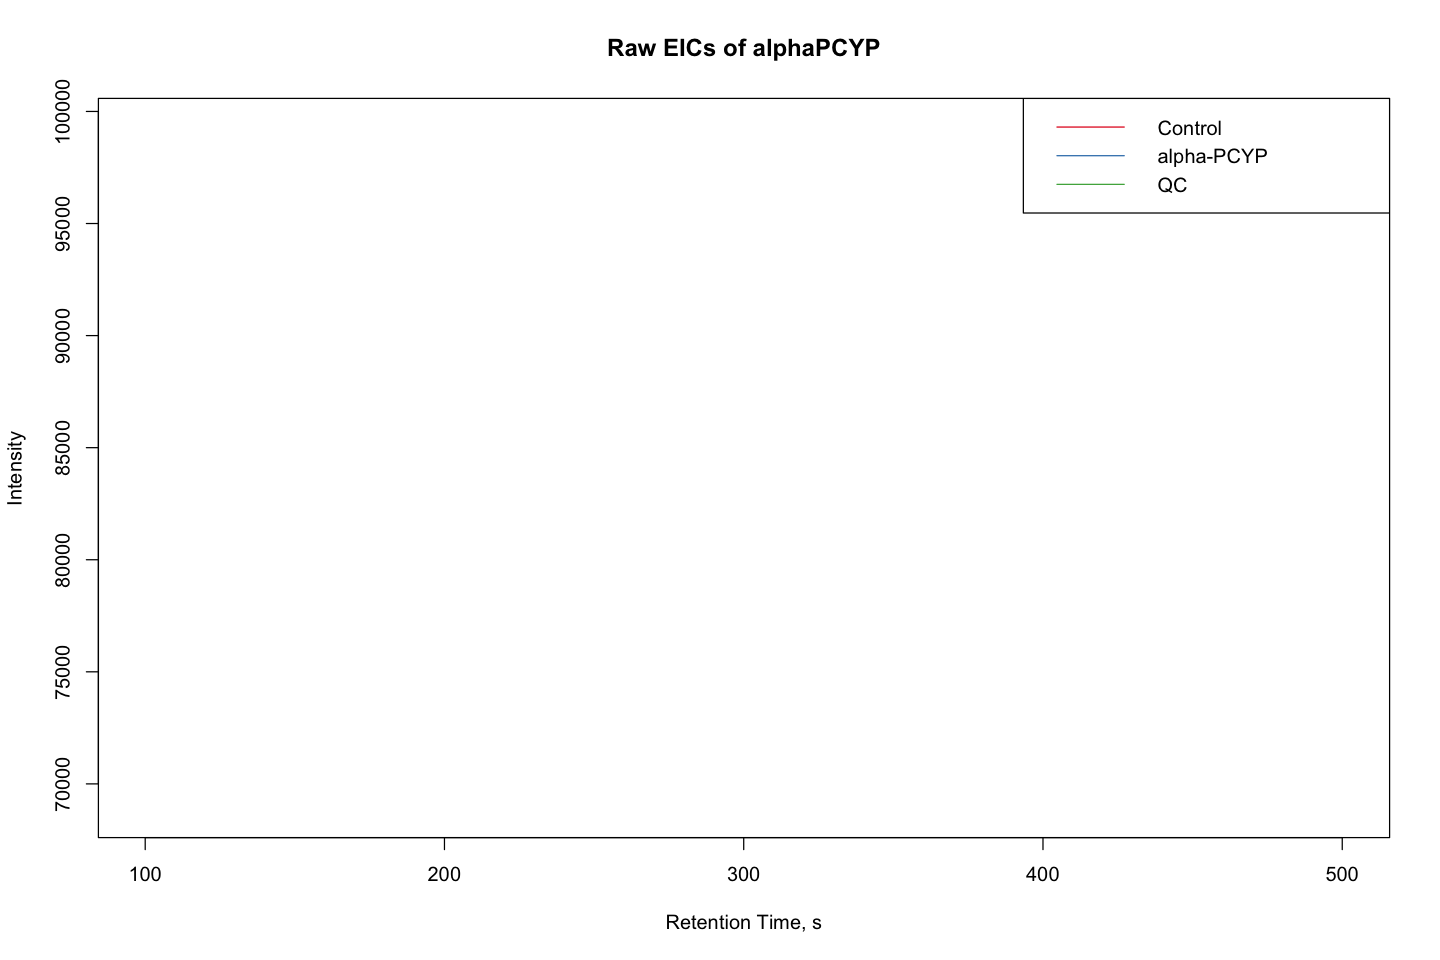

In [8]:
## Plot raw EICs of alpha-PCYP (m/z 272.2008, 25 s)
alphaPCYP.raw <- chromatogram(raw, mz = c(272.2000, 272.2015), rt = c(100, 500))

plot(alphaPCYP.raw, col = group.colours[alphaPCYP.raw$sample_group], 
     main = bquote(bold("Raw EICs of alphaPCYP")), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

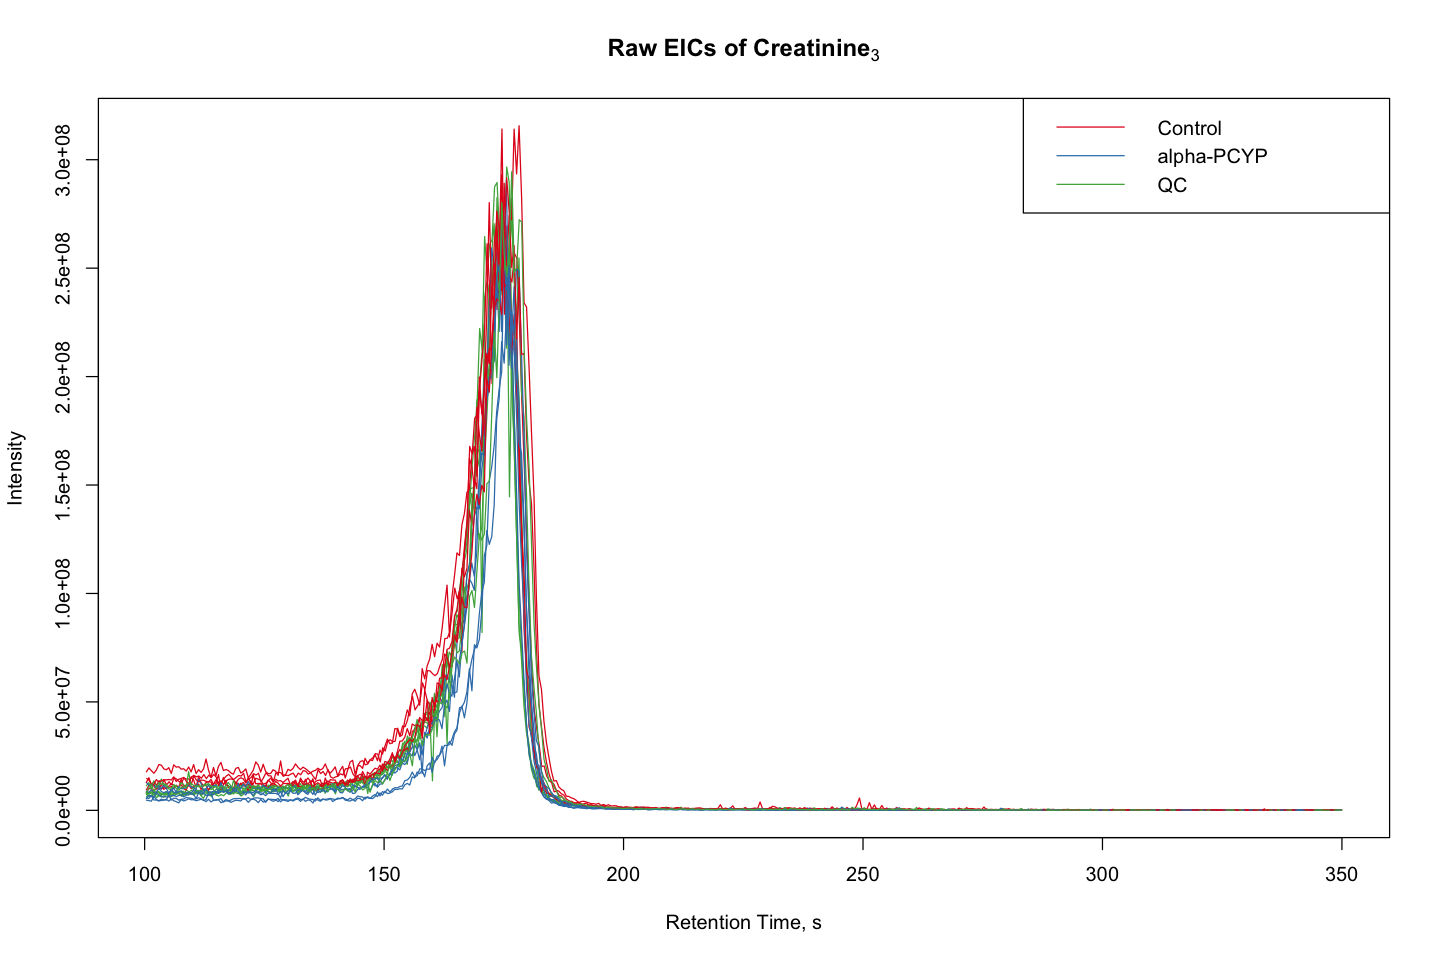

In [9]:
## Plot raw EICs of creatinine (m/z 114.0665, 25 s)
crea.raw <- chromatogram(raw, mz = c(114.0645, 114.0685), rt = c(100, 350))

plot(crea.raw, col = group.colours[crea.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [10]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

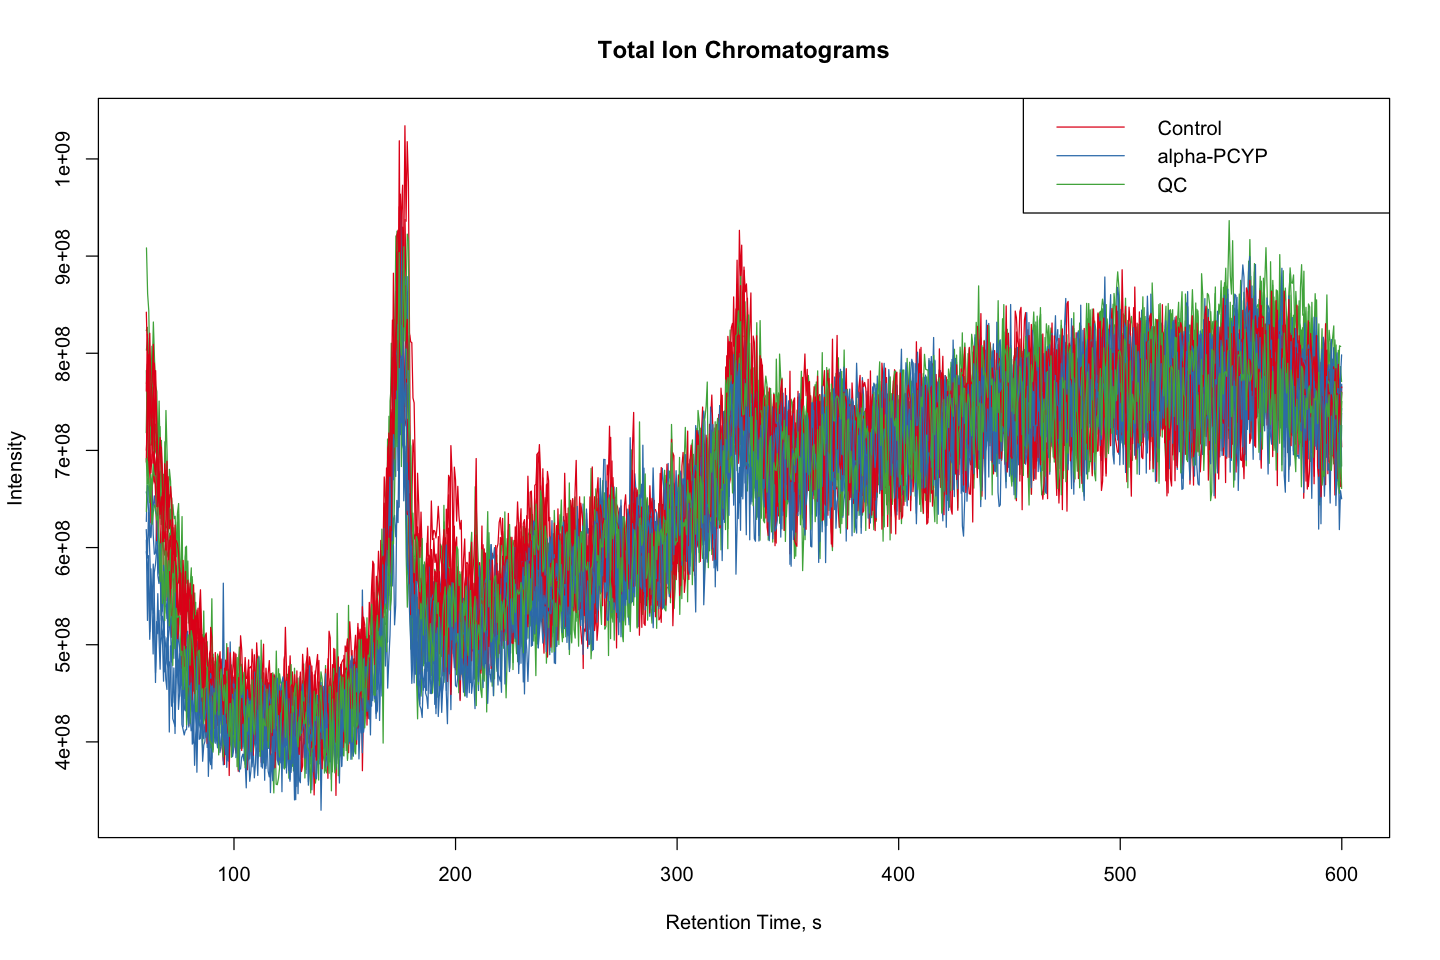

In [11]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

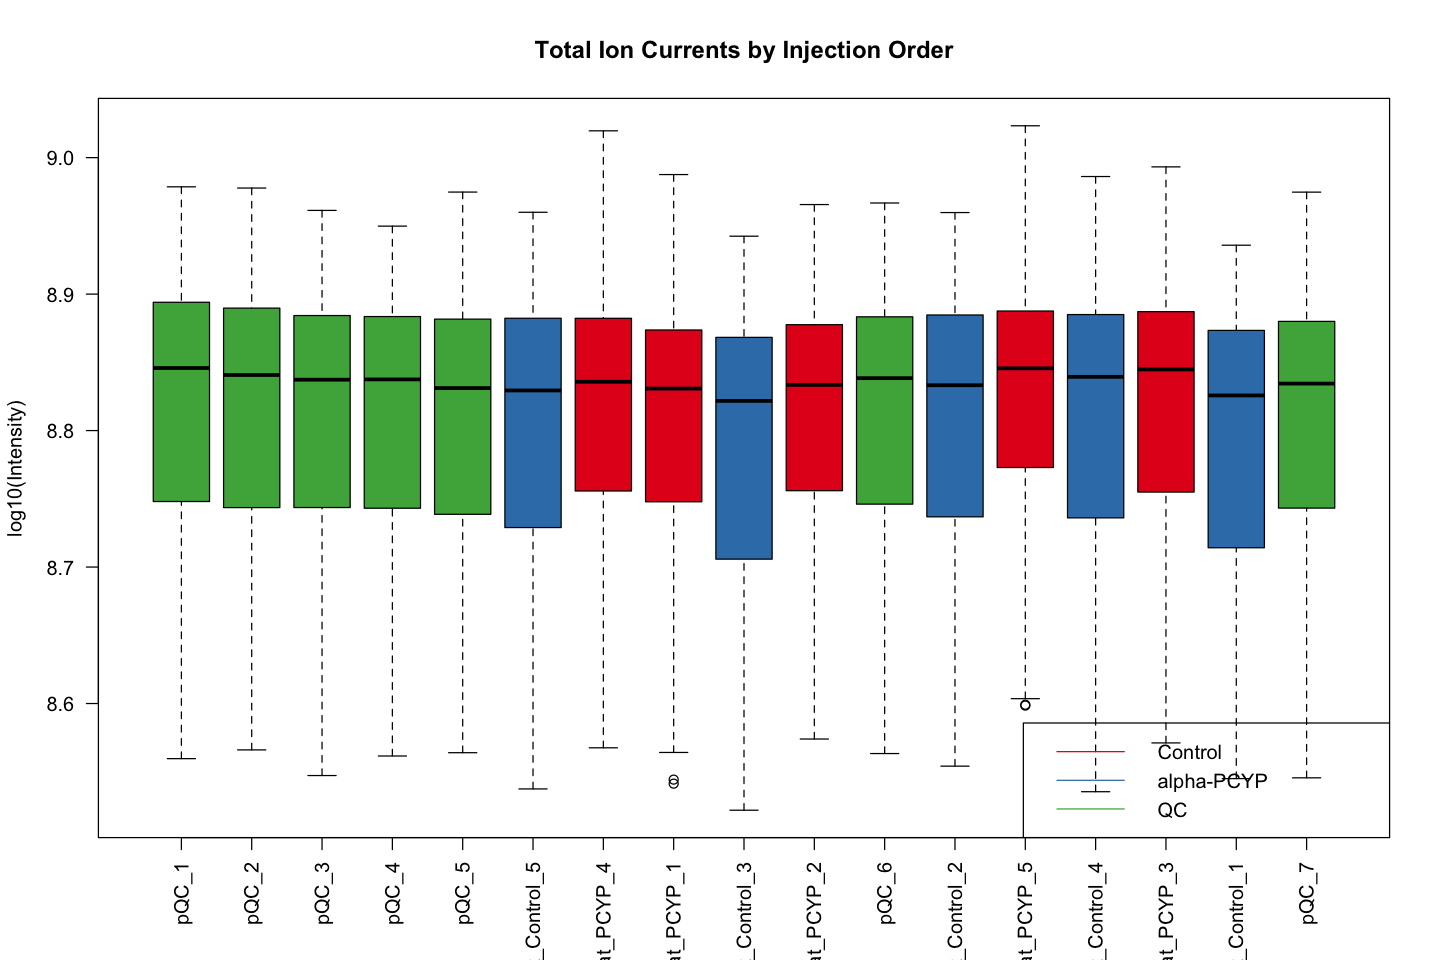

In [12]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [13]:
cwp <- CentWaveParam(peakwidth = c(9, 15), ppm = 1.5, snthresh = 30, 
                     mzdiff = 0.024,  prefilter = c(5, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [14]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Control", "alpha-PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

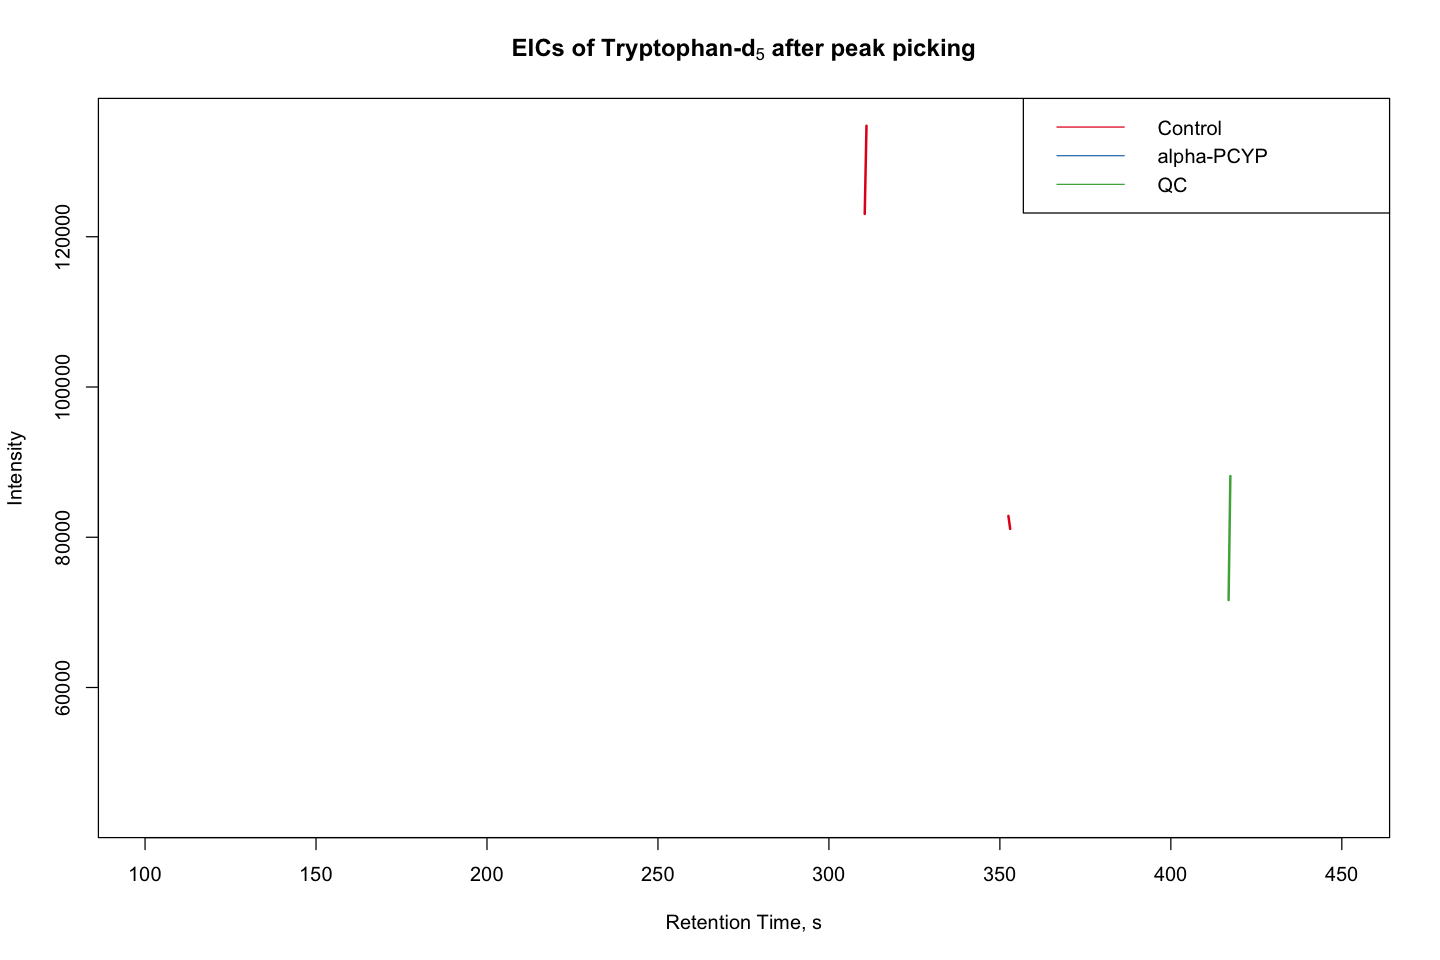

In [15]:
## Plot Tryptophan-d5 after peak picking (m/z 210.1291, 168 s)
trpd5.picked <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 450)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

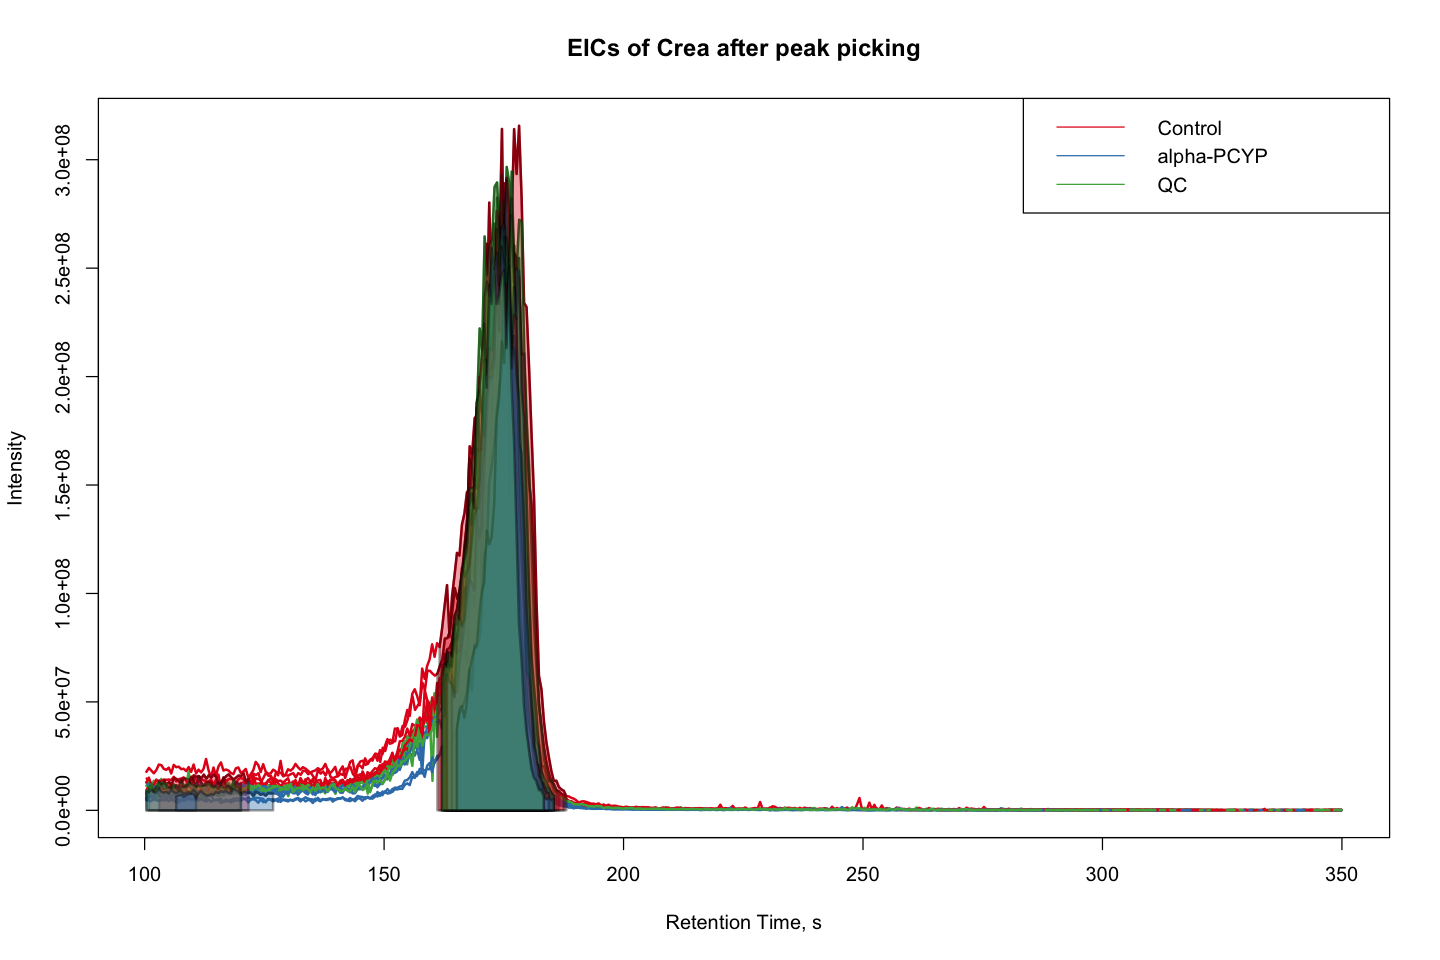

In [16]:
## Plot Crea after peak picking (m/z 114.0665, 287s)
crea.picked <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(100, 350)) 

plot(crea.picked, col = group.colours[crea.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(crea.picked)[, "sample"]],
     main = bquote(bold("EICs of Crea after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

Warning message in .local(x, ...):
“All chromatograms empty”


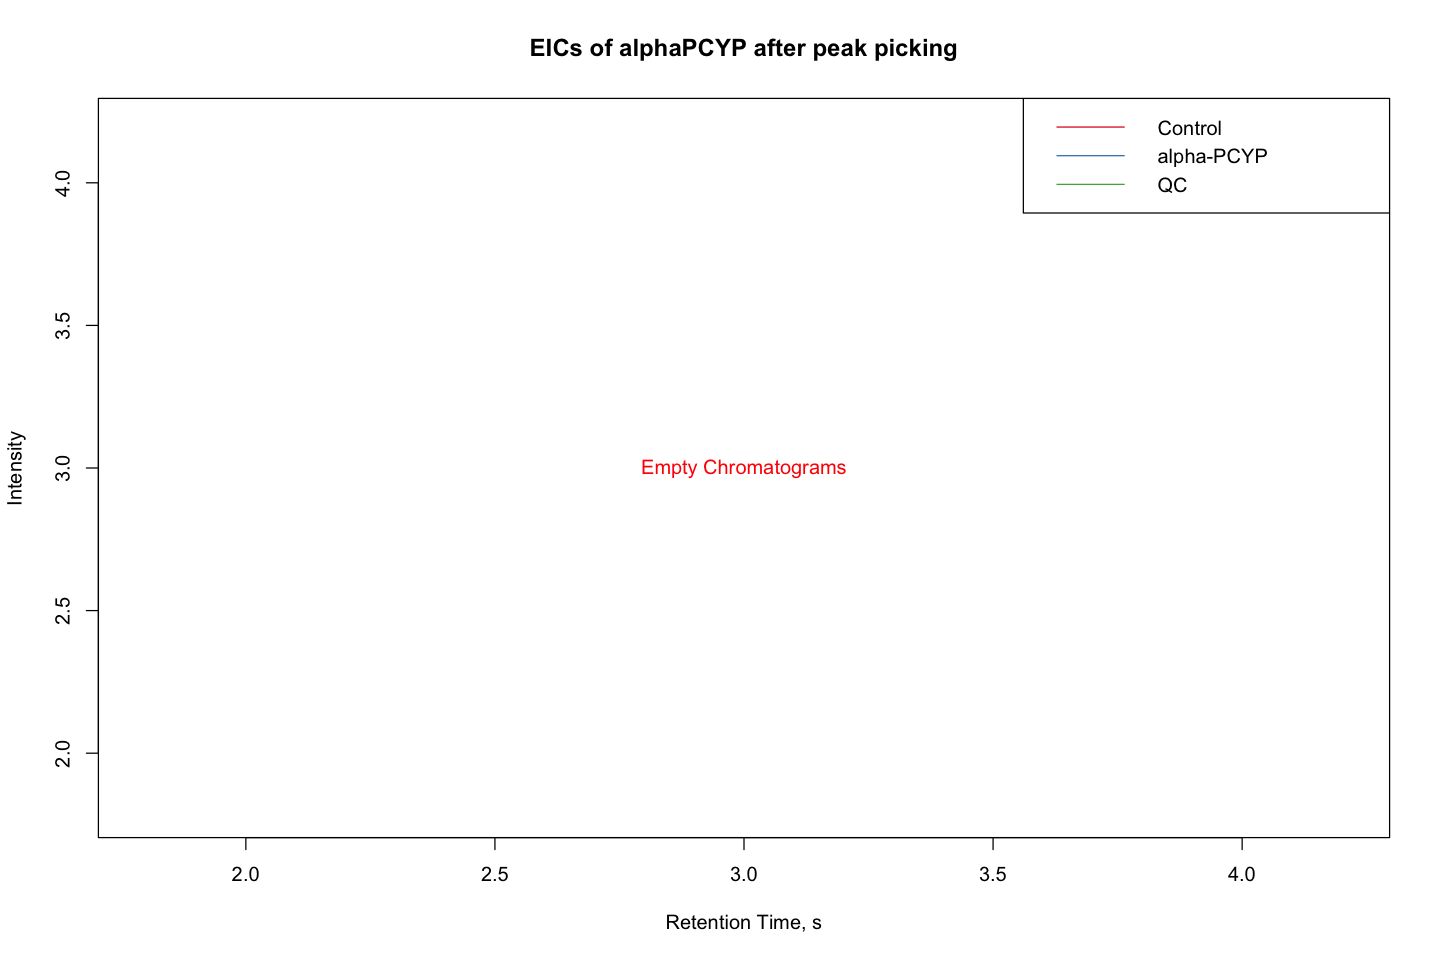

In [17]:
## Plot alpha-PCYP after peak picking (m/z 272.2008, 314 s)
alphaPCYP.picked <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 240)) 

plot(alphaPCYP.picked, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.picked)[, "sample"]],
     main = bquote(bold("EICs of alphaPCYP"*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [18]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1.0)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

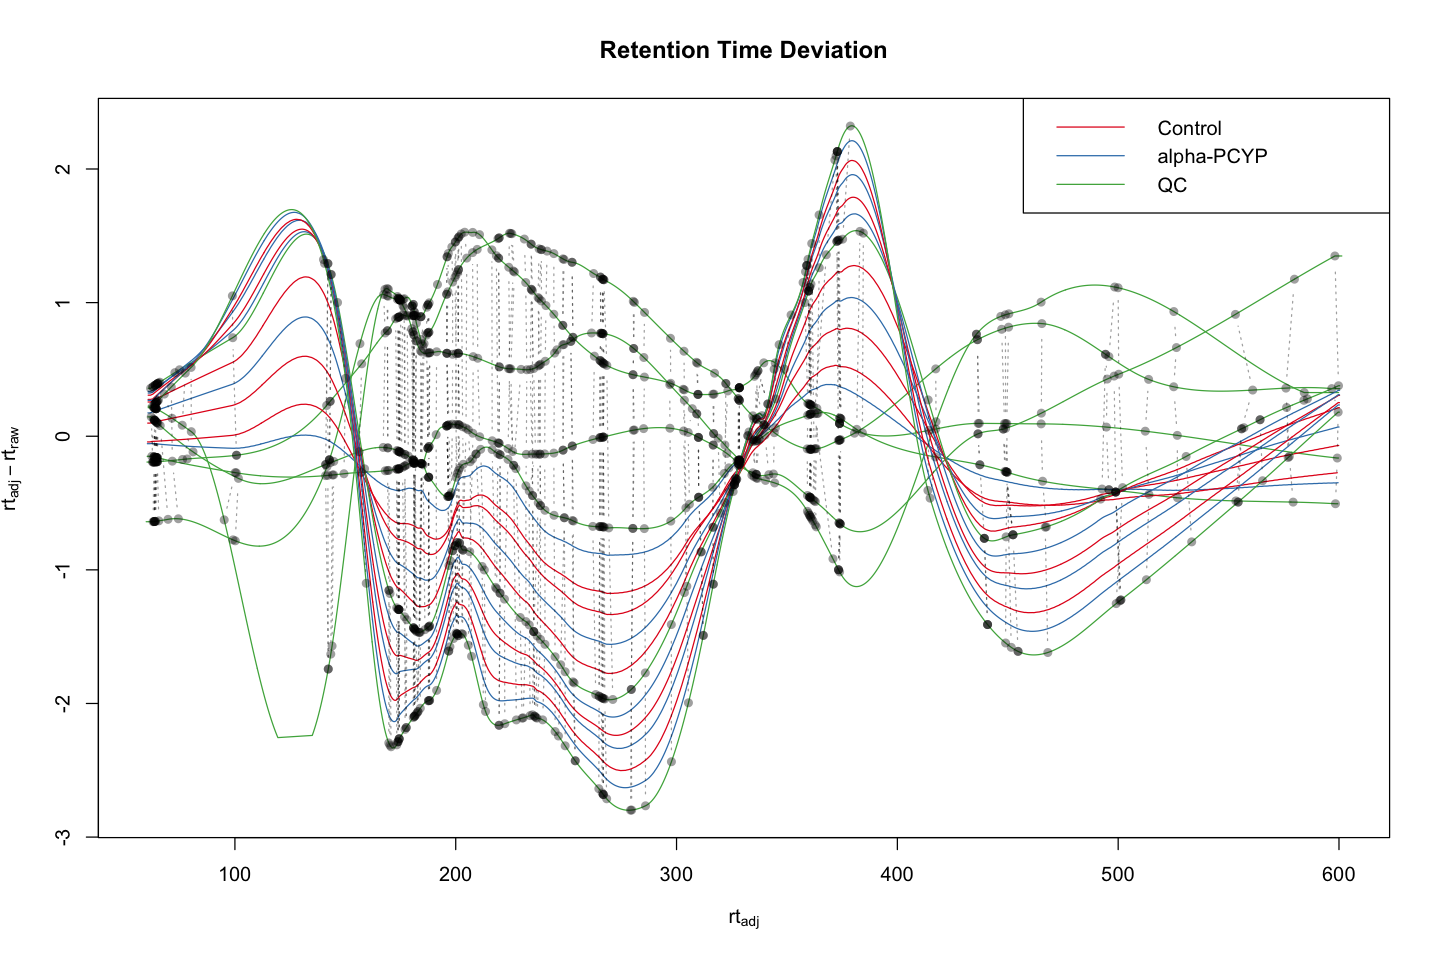

In [19]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

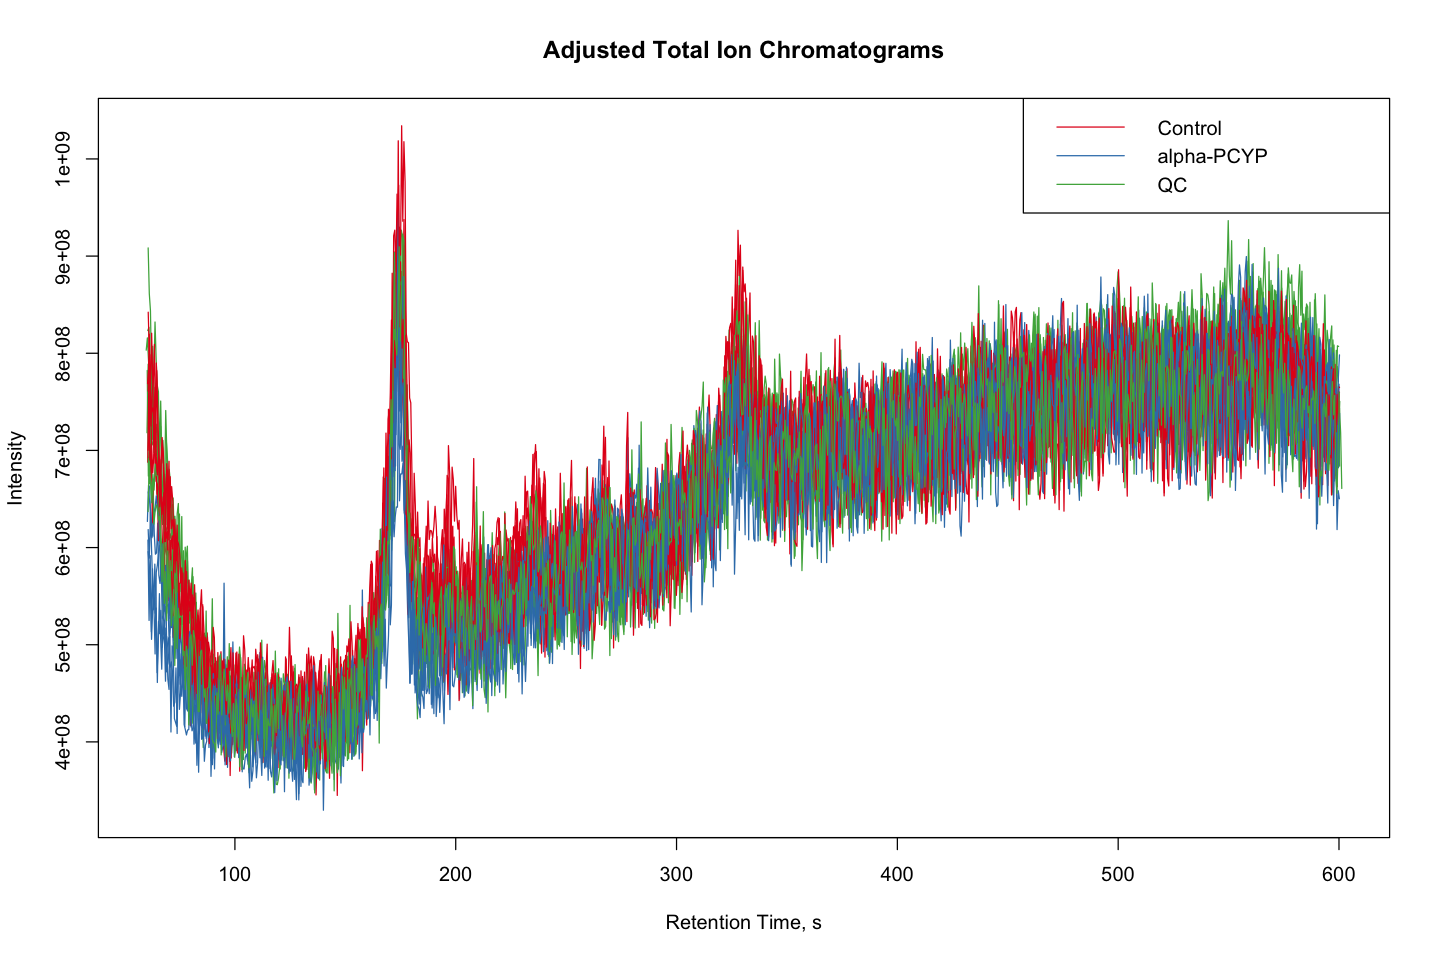

In [20]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

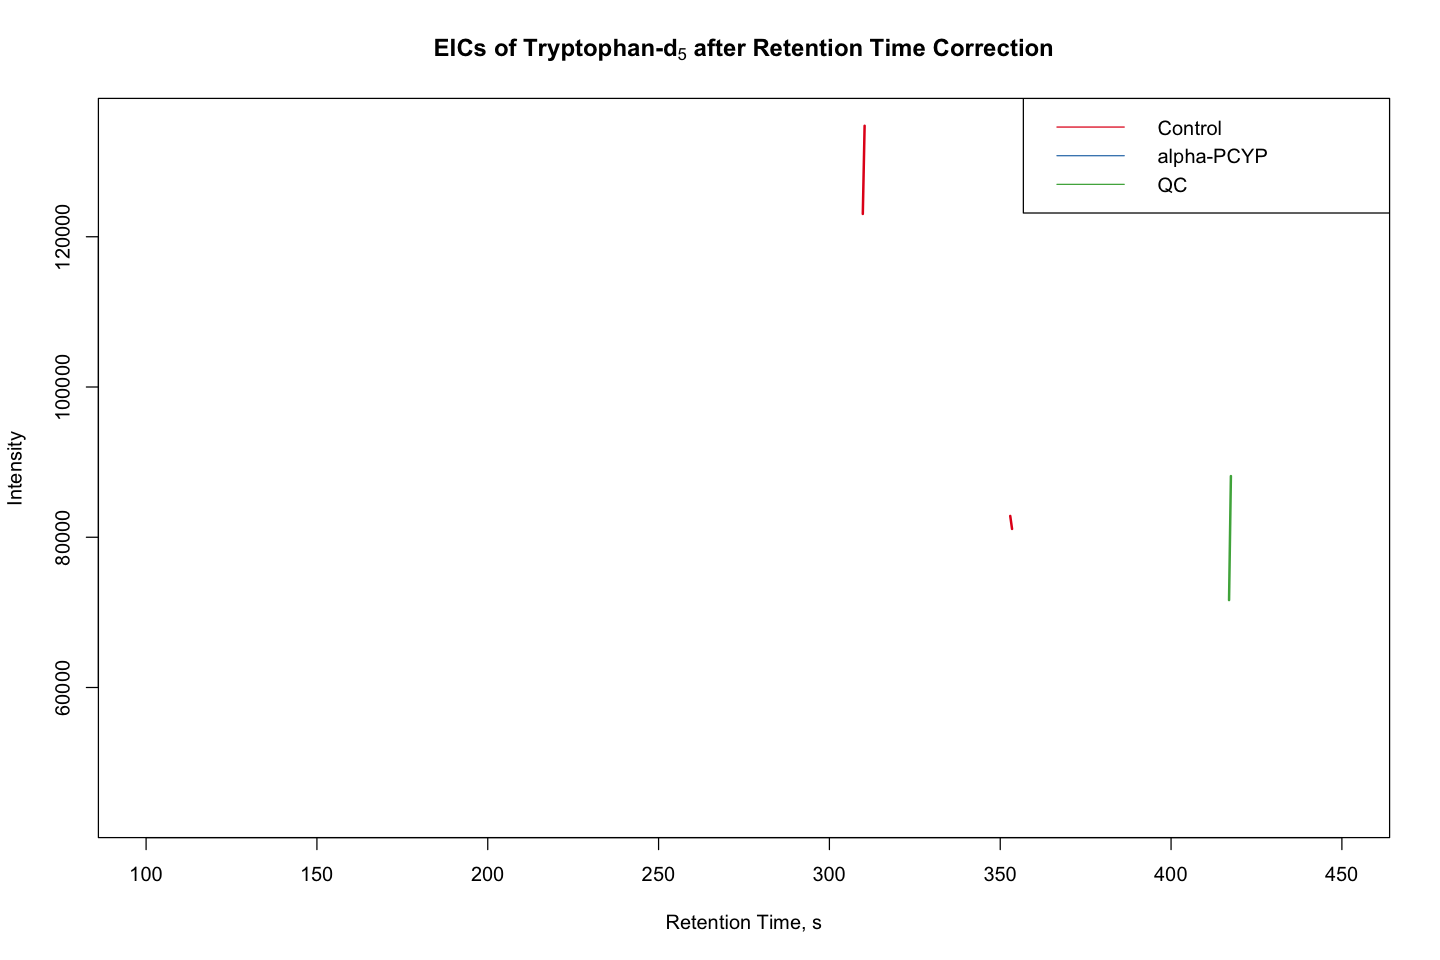

In [21]:
## Plot tryptophan-d5 after retention time correction (m/z 210.1291, 168 s)
trpd5.corr <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 450))

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

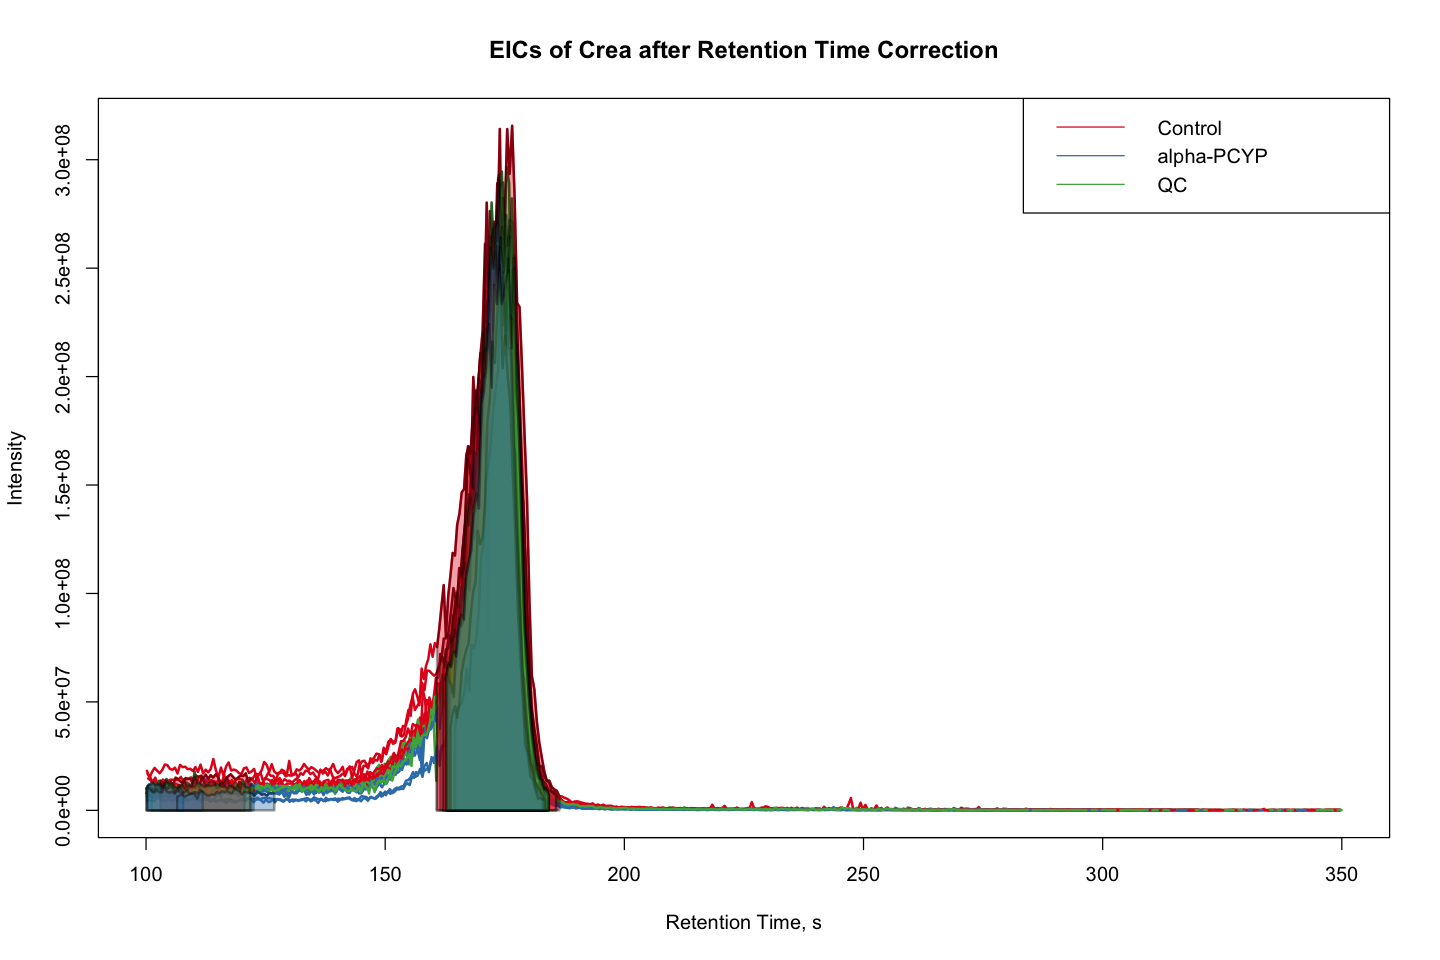

In [22]:
## Plot Crea after after retention time correction (m/z 114.0665, 287 s)
crea.corr <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(100, 350))

plot(crea.corr, col = group.colours[crea.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(crea.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of Crea after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

Warning message in .local(x, ...):
“All chromatograms empty”


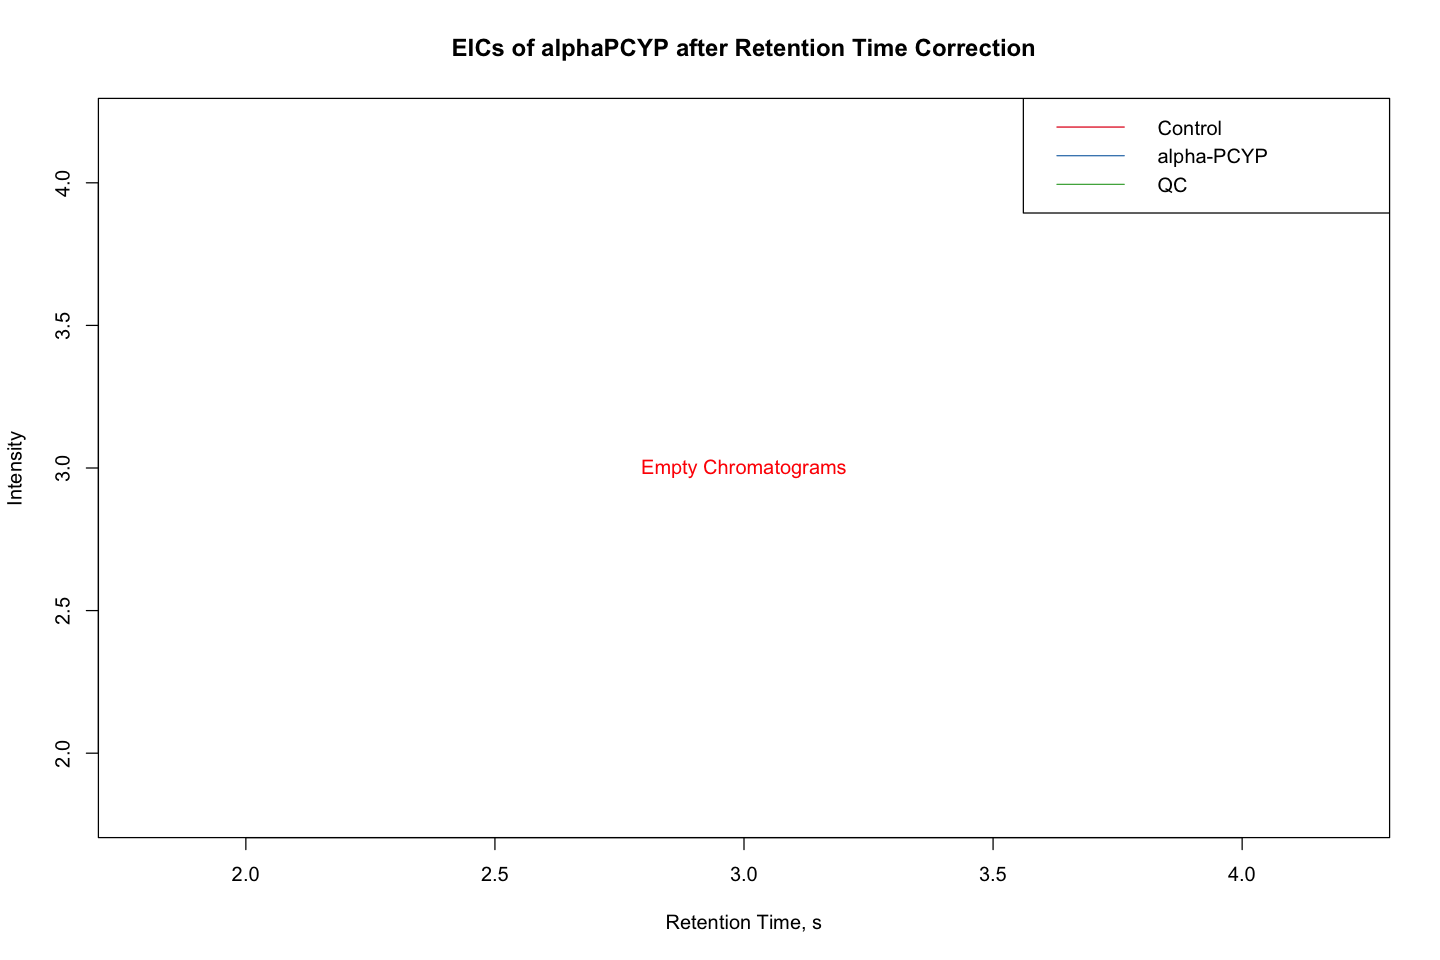

In [23]:
## Plot alpha-PCYP after retention time correction (m/z 272.2008, 314 s)
alphaPCYP.corr <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(100, 240))

plot(alphaPCYP.corr, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [24]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

In [25]:
## Plot trp-d5 after peak grouping
trpd5.grouped <- chromatogram(set, mz = c(210.1281, 210.1301), rt = c(100, 400))

## Define the parameters for the peak density method
plotChromPeakDensity(trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

ERROR: Error: No chromatographic peaks present. Please run 'findChromPeaks' first.


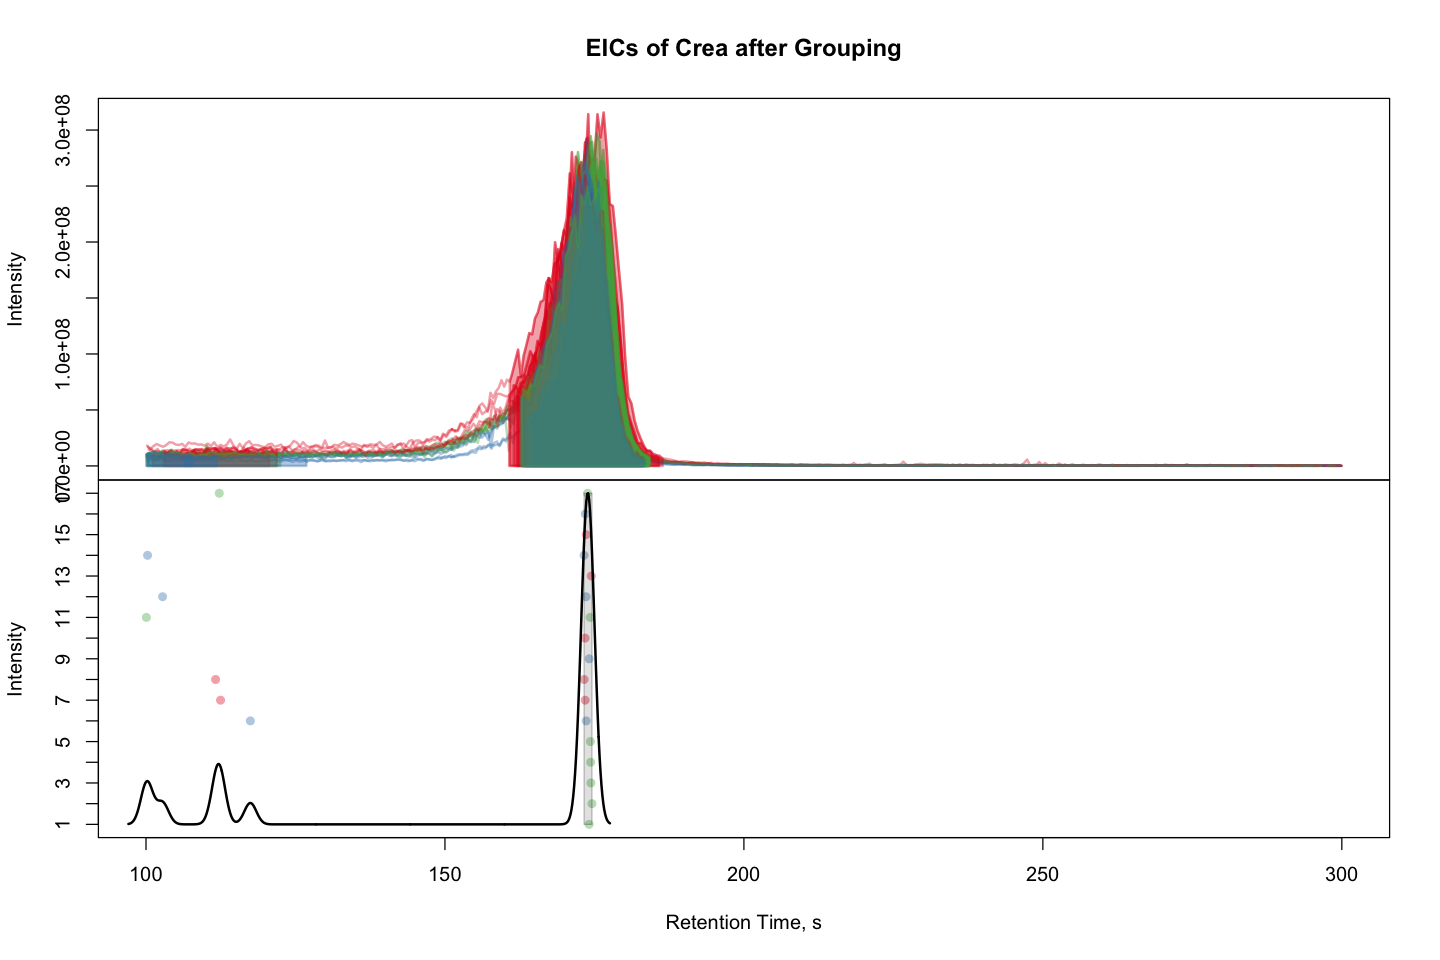

In [26]:
## Plot Crea after peak grouping
crea.grouped <- chromatogram(set, mz = c(114.0645, 114.0685), rt = c(100, 300))

## Define the parameters for the peak density method
plotChromPeakDensity(crea.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(crea.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Crea after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

# Peak Filling

In [27]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'param' bei der Methodenauswahl für Funktion 'fillChromPeaks': konnte Funktion "ChromPeakAreaParam" nicht finden


# Postprocessing


# Annotation of Adducts and Isotopes

In [28]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [29]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
          mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
      <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT001   62.0439   62.0376   62.0439   64.4257   63.4682   64.9492        11
FT002   79.0220   79.0219   79.0220   65.1538   64.7747   65.9981        10
FT003   84.0815   84.0814   84.0816   65.9848   64.9423   67.5591         8
FT004   86.0607   86.0607   86.0608  181.3906  180.7761  182.7486         9
FT005   94.0457   94.0456   94.0457  319.1505  315.6795  321.9732         9
FT006   94.0457   94.0456   94.0457  583.9895  581.9425  584.5881         6
      alpha.PCYP   Control        QC            peakidx  ms_level
       <numeric> <numeric> <numeric>             <list> <integer>
FT001          1         4         6    122,396,686,...         1
FT002          4         4         2 1896,2394,2694,...         1
FT003          2         3         3  775,1262,1862,...         1
FT004          3         

In [30]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
          mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
      <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT001   62.0439   62.0376   62.0439   64.4257   63.4682   64.9492        11
FT002   79.0220   79.0219   79.0220   65.1538   64.7747   65.9981        10
FT003   84.0815   84.0814   84.0816   65.9848   64.9423   67.5591         8
FT004   86.0607   86.0607   86.0608  181.3906  180.7761  182.7486         9
FT005   94.0457   94.0456   94.0457  319.1505  315.6795  321.9732         9
FT006   94.0457   94.0456   94.0457  583.9895  581.9425  584.5881         6
      alpha.PCYP   Control        QC            peakidx  ms_level       label
       <numeric> <numeric> <numeric>             <list> <integer> <character>
FT001          1         4         6    122,396,686,...         1      M62T64
FT002          4         4         2 1896,2394,2694,...         1      M79T65
FT003          2         3         3  775,1

In [31]:
assay(results) %>% 
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT001  43686040   50983574     39352317   55065589     43145748  
FT002        NA         NA           NA         NA           NA  
FT003        NA         NA    106748019         NA    107998354  
FT004  33752567         NA           NA   36749524           NA  
FT005 245570646         NA           NA         NA           NA  
FT006 745784977         NA           NA         NA           NA  
      24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT001        NA                      41769945                 
FT002        NA                     130031201                 
FT003        NA                     123449055                 
FT004  36223167                      35162611                 
FT005 149845782                     217763557                 
FT006 275298767                            NA                 
      24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT001  37122901                         NA                    
FT002        NA                  117147444                    
FT003 126067147                         NA                    
FT004  30507046                   31255211                    
FT005 104935246                  185454019                    
FT006        NA                  246385539                    
      24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT001  37042986                   35226702    18663187                    
FT002 101051210                  104968772   103684048                    
FT003        NA                  125700679   153282503                    
FT004  37653801                   30331715    34008891                    
FT005 194073526                  220304608   217991979                    
FT006 471557392                  240486545   384389044                    
      24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT001  41125743                        NA                     
FT002  77092630                  85993300                     
FT003 169381742                        NA                     
FT004        NA                        NA                     
FT005        NA                        NA                     
FT006        NA                        NA                     
      24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT001       NA                          NA                           NA   
FT002 92048300                   111561236                     95441733   
FT003       NA                   150681360                           NA   
FT004       NA                          NA                           NA   
FT005       NA                   237259580                           NA   
FT006       NA                          NA                           NA

In [32]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 70 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 29 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 70 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 70 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  163 
xsAnnotate has now 163 groups, instead of 70 
Generating peak matrix for peak annotation!

Calculating possible adducts in 163 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [33]:
assays(results)

List of length 1
names(1): raw

In [34]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [35]:
assays(results)

List of length 2
names(2): raw scaled

In [36]:
results %>%
assay("scaled") %>%
head()

pQC_1.mzXML pQC_2.mzXML pQC_3.mzXML pQC_4.mzXML pQC_5.mzXML
FT001 7.640343    7.707430    7.594970    7.740880    7.634938   
FT002 5.605346    5.605346    5.605346    5.605346    5.605346   
FT003 5.605346    5.605346    8.028360    5.605346    8.033417   
FT004 7.528307    5.605346    5.605346    7.565252    5.605346   
FT005 8.390176    5.605346    5.605346    5.605346    5.605346   
FT006 8.872614    5.605346    5.605346    5.605346    5.605346   
      24h_Urine_Rat_Control_5.mzXML 24h_Urine_Rat_PCYP_4.mzXML
FT001 5.605346                      7.620864                  
FT002 5.605346                      8.114048                  
FT003 5.605346                      8.091488                  
FT004 7.558986                      7.546081                  
FT005 8.175645                      8.337985                  
FT006 8.439804                      5.605346                  
      24h_Urine_Rat_PCYP_1.mzXML 24h_Urine_Rat_Control_3.mzXML
FT001 7.569642                   5.605346                     
FT002 5.605346                   8.068733                     
FT003 8.100602                   5.605346                     
FT004 7.484400                   7.494922                     
FT005 8.020921                   8.268236                     
FT006 5.605346                   8.391615                     
      24h_Urine_Rat_PCYP_2.mzXML pQC_6.mzXML 24h_Urine_Rat_Control_2.mzXML
FT001 7.568706                   7.546872    7.270986                     
FT002 8.004542                   8.021060    8.015712                     
FT003 5.605346                   8.099338    8.185493                     
FT004 7.575809                   7.481897    7.531592                     
FT005 8.287966                   8.343024    8.338441                     
FT006 8.673535                   8.381091    8.584771                     
      24h_Urine_Rat_PCYP_5.mzXML 24h_Urine_Rat_Control_4.mzXML
FT001 7.614114                   5.605346                     
FT002 7.887013                   7.934465                     
FT003 8.228867                   5.605346                     
FT004 5.605346                   5.605346                     
FT005 5.605346                   5.605346                     
FT006 5.605346                   5.605346                     
      24h_Urine_Rat_PCYP_3.mzXML 24h_Urine_Rat_Control_1.mzXML pQC_7.mzXML
FT001 5.605346                   5.605346                      5.605346   
FT002 7.964016                   8.047513                      7.979738   
FT003 5.605346                   8.178060                      5.605346   
FT004 5.605346                   5.605346                      5.605346   
FT005 5.605346                   8.375224                      5.605346   
FT006 5.605346                   5.605346                      5.605346

# Normalisation

In [82]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [83]:
## Identify rownumber of internal standard tryptophan-d5
crea <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 114.0665, rt = 287, 5, 10)

In [84]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = trpd5)

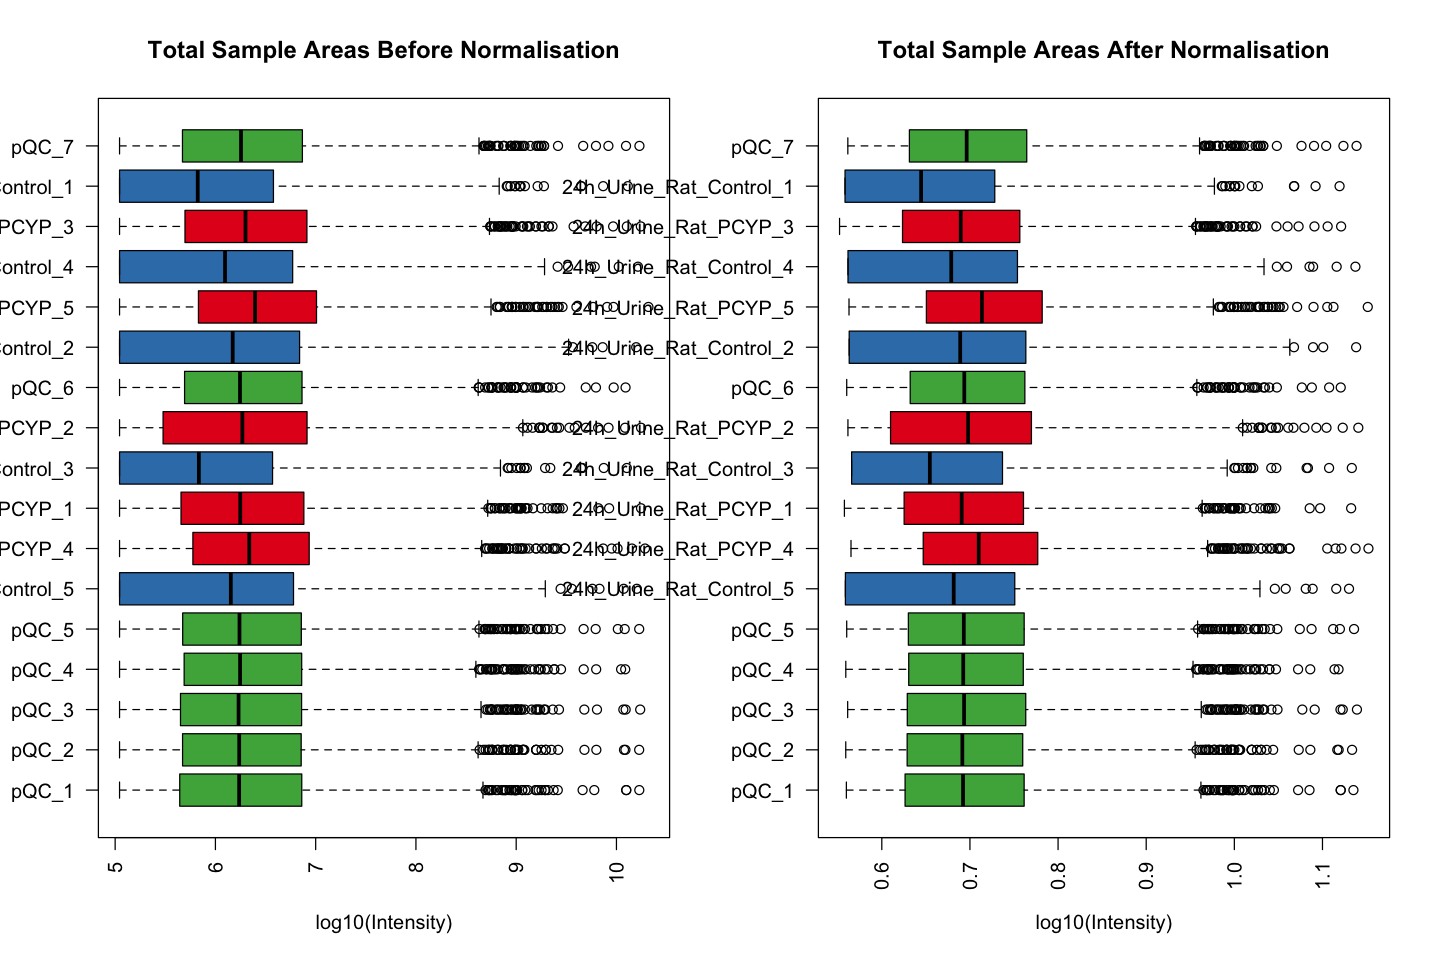

In [85]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [37]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [38]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [39]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

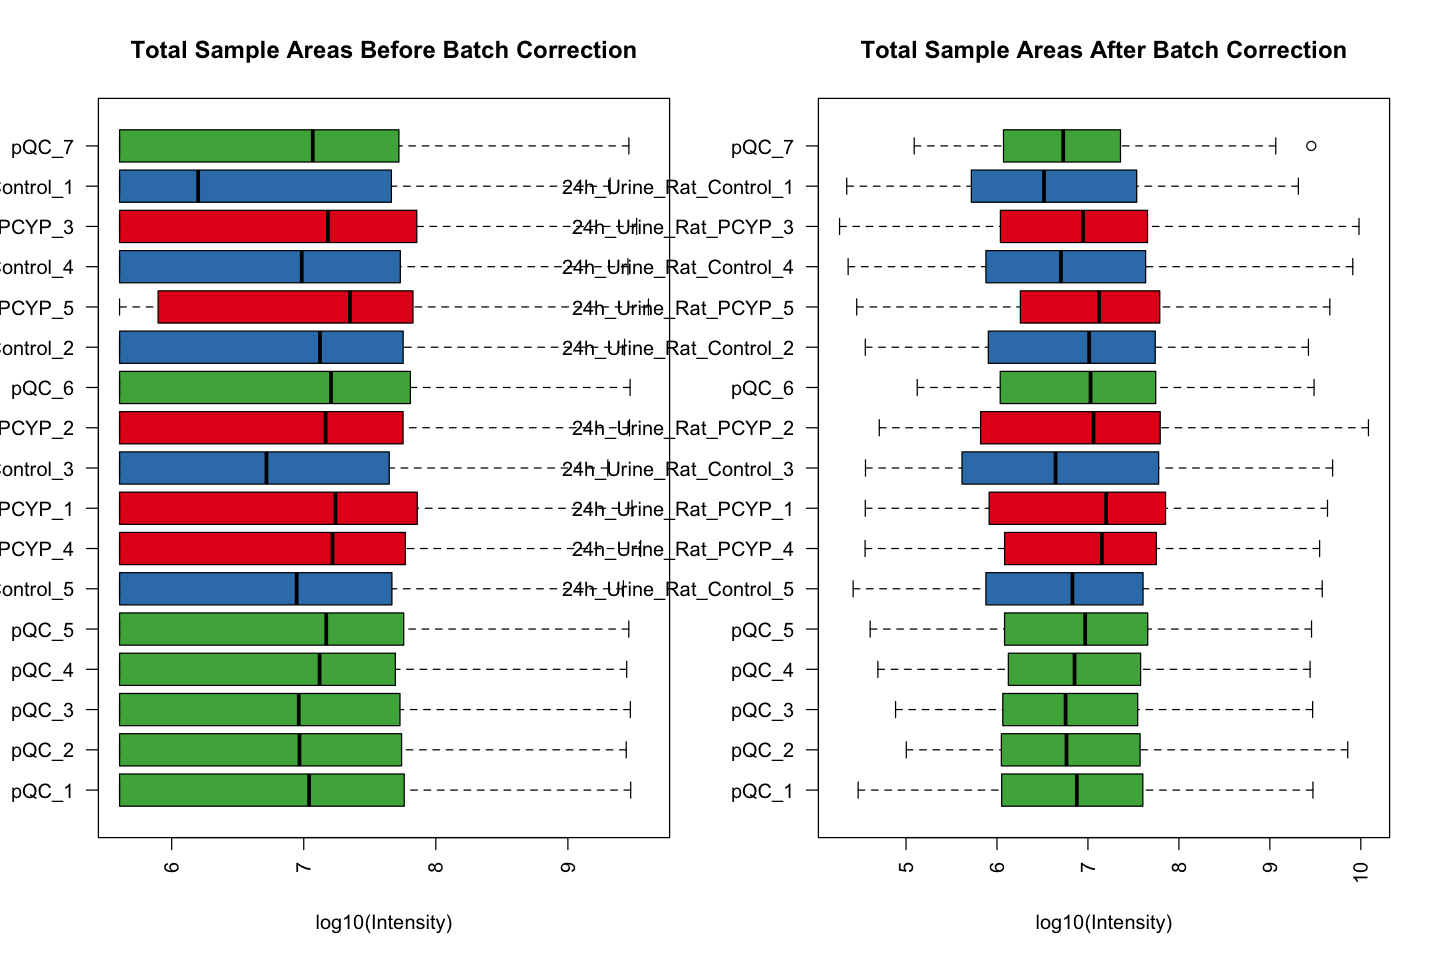

In [40]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [41]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

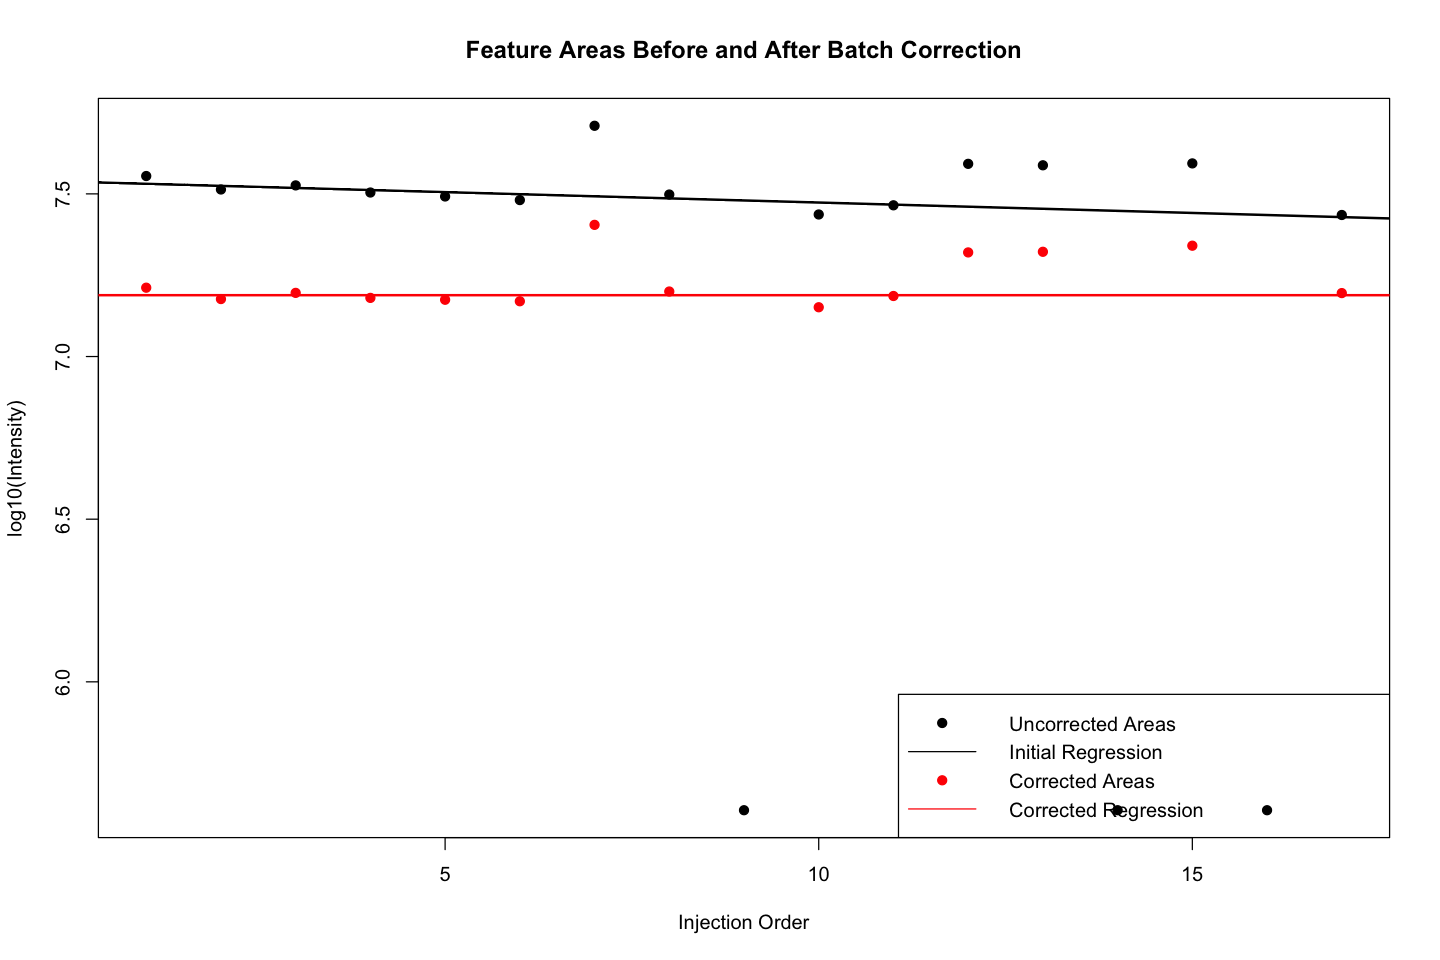

In [42]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))